### Introduction to Hydro, etc...

### Introduction to Bayes THM, etc...

## Defining our physics model

We will use a linear model for the hydrodynamic response of the elliptic flow $v_2$ to the specific shear viscosity $\eta/s$.

Ordinarily we would use a hydrodynamic simulation to model the physics, but we use a linear-model in this notebook because its not computationally demanding, allowing us to focus on concepts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#sns.set_context('talk')
import time

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.preprocessing import StandardScaler

import emcee
import corner

In [2]:
#Our linear model for hydrodynamic response
#note output is a particular centrality bin, 20-30

#noise level controls statistical scatter in our physics model
noise = 0.1 #amount of statistical scatter in our training calculations

#this function will play the role of a realistic event-by-event hydrodynamic model
def lin_hydro_model(eta_over_s, intercept = 0.12, slope = -0.25, noise = 0.05): 
    y = intercept + slope * (eta_over_s) # the mean model prediction
    dy = noise * y * np.random.normal() #the model stat error
    y += dy # add the model stat. error to the model mean
    y = np.max([0., y]) #suppose our measurement definition is positive definite
    return y, dy

lin_hydro_model = np.vectorize(lin_hydro_model)

### Training our Emulator

Normally, a real hydrodynamic physics model could take hours to run a single event, and we may need thousands of events to construct a centrality average. Therefore, for computationally demanding models we can employ a fast surrogate (interpolation) which can estimate the interpolation uncertainty. We can use a Gaussian Process!

We will first train our Gaussian Process by running our physics simulation on a sampling of points that fill our parameter space...

/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]


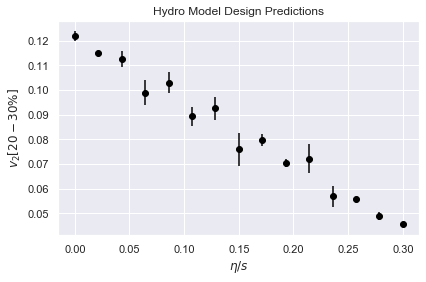

In [3]:
#these will be the values of eta/s where we run our hydro model
n_design_pts = 15 # this sets the number of design points where we will run our hydro model
eta_over_s_min = 0. # this defines a minmum value for eta/s
eta_over_s_max = 0.3 # this defines a maximum value for eta/s


model_X = np.linspace(eta_over_s_min, eta_over_s_max, n_design_pts).reshape(-1,1)

#these are the v_2 outputs of our hydro model, assuming that the model has finite statistical error
model_y, model_dy = lin_hydro_model(model_X)

#lets plot our physics models predictions
plt.errorbar(model_X, model_y, model_dy, fmt='o', c='black')
plt.xlabel(r'$\eta/s$')
plt.ylabel(r'$v_2 [ 20-30\%]$')
plt.title('Hydro Model Design Predictions')
plt.tight_layout(True)
plt.show()

### Setting some bounds on the hyperparameters of our GP kernels, choosing GP kernels, etc...

In [4]:
ptp = max(model_X) - min(model_X)
rbf_kern = 1. * kernels.RBF(
                      length_scale=ptp,
                      length_scale_bounds=np.outer(ptp, (1e-2, 1e2)),
                      )

white_kern = kernels.WhiteKernel(
                         noise_level=.1,
                         noise_level_bounds=(1e-2, 1e1)
                        )
my_kernel = (rbf_kern + white_kern) 

### Scaling our model observables -> (-1, 1) for better GP peformance

In [5]:
model_y_copy = model_y.copy()
scaler = StandardScaler(copy=True).fit(model_y_copy)
scaled_model_y = scaler.transform(model_y, copy=True)

### Training our GP on the hydro model calculations

In [6]:
nrestarts=10

#define our Gaussian process, and fit it to the hydro model calculations
my_gp = GPR(kernel=my_kernel,
         alpha=0.01, # the nugget, to stabilize matrix inversions
         n_restarts_optimizer=nrestarts, 
         ).fit(model_X, 
               scaled_model_y
              )

In [7]:
#Convenient to define a function that handles the scaling and interpolation together
#This map is our 'emulator'
def emu_predict(eta_over_s):
    X = eta_over_s.reshape(-1, 1)
    scaled_y, scaled_dy = my_gp.predict(X, return_std=True)
    y = scaler.inverse_transform(scaled_y).reshape(len(eta_over_s))
    dy = scaled_dy * scaler.scale_
    return y, dy

### Let's check how our GP model fits the hydro model

/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


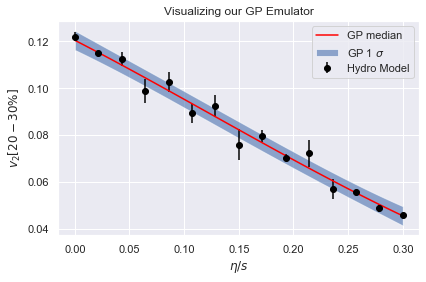

In [8]:
n_test_pts = 100
gp_X_test = np.linspace(eta_over_s_min, eta_over_s_max, n_test_pts)

y_pred, dy_pred = emu_predict(gp_X_test)

plt.plot(gp_X_test, y_pred, color='red', label='GP median')
plt.fill_between(gp_X_test, y1 = y_pred - dy_pred, y2 = y_pred + dy_pred, 
                 interpolate=True, alpha=0.6, label=r'GP 1 $\sigma$')

plt.errorbar(model_X, model_y, model_dy, fmt='o', c='black', label='Hydro Model')

plt.xlabel(r'$\eta/s$')
plt.ylabel(r'$v_2 [ 20-30\%]$')
plt.title('Visualizing our GP Emulator')
plt.legend()
plt.tight_layout(True)
plt.show()

### Before using experimental data to update our belief about $\eta/s$, we need to define our prior belief about $\eta/s$

In [9]:
#define two different priors, one more informed than the other
theta_min = eta_over_s_min
theta_max = eta_over_s_max

#a flat prior
def log_flat_prior(theta):
    """Flat prior on value between limits"""
    if (theta_min < theta) and (theta < theta_max):
        return 0. # log(1)
    else:
        return -np.inf  # log(0)
    
#a peaked prior
prior_peak = 3. / (4. * np.pi) # the value of eta/s we belief most likely, before seeing data
prior_width = 1. / (4. * np.pi) #our uncertainty about this value, before seeing the data
def log_peaked_prior(theta):
    """Flat prior on value between limits"""
    if (theta_min < theta) and (theta < theta_max):
        return -0.5 * (theta - prior_peak)**2. / prior_width**2. 
    else:
        return -np.inf  # log(0)

### We need to define our likelihood function
The likelihood is a model for the conditional probability of observing the data given a parameter. Specifically,
the probability of observing some experimental value for $v_2$ given some value of $\eta/s$.

In [10]:
def log_likelihood(theta, y_exp, dy_exp):
    #use our GP emulator to approximate the hydro model
    y_pred, dy_pred = emu_predict(theta) # emulation prediction and uncertainty
    dy_tot = np.sqrt( dy_pred**2. + dy_exp**2. ) #total uncertainty, emulation and exp.
    return -0.5 * np.sum( (y_pred - y_exp)**2 / dy_tot**2 )

In [11]:
#posterior using flat prior
def log_posterior_1(theta, y_exp, dy_exp):
    '''Log posterior for data X given parameter array theta'''
    return log_flat_prior(theta) + log_likelihood(theta, y_exp, dy_exp)

#posterior using peaked prior
def log_posterior_2(theta, y_exp, dy_exp):
    '''Log posterior for data X given parameter array theta'''
    return log_peaked_prior(theta) + log_likelihood(theta, y_exp, dy_exp)

### Now, we want to infer the value of $\eta/s$ by using some experimental data

Suppose that an experiment measures $v_2[20-30\%]$, and is reported by a mean value and total uncertainty...

In [12]:
exp_rel_uncertainty = 0.1
y_exp = 0.09 #v_2 exp. mean
dy_exp = y_exp * exp_rel_uncertainty #v_2 exp. uncertainty

In [13]:
ndim = 1  # number of parameters in the model
nwalkers = 20*ndim  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations within the prior volume
starting_guesses = theta_min + \
                   (theta_max - theta_min) * np.random.rand(nwalkers,ndim)

print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_1, args=[y_exp, dy_exp])

# "burn-in" period; save final positions and then reset
pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
sampler.reset()

# sampling period
sampler.run_mcmc(pos, nsteps)

print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers
Mean acceptance fraction: 0.809 (in total 40000 steps)


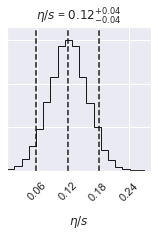

In [14]:
# make a corner plot with the posterior distribution
fig = corner.corner(samples, labels=["$\eta/s$"],
                    quantiles=[0.05, 0.5, 0.95],
                    show_titles=True, title_kwargs={"fontsize": 12})